In [1]:
import pandas as pd

df = pd.read_csv('temperature.csv')
print("First 10 rows of the dataframe")
print(df.head(10))

First 10 rows of the dataframe
                  Station Name   Measurement Timestamp  Air Temperature
0  63rd Street Weather Station  01/01/2016 12:00:00 AM            -2.80
1   Oak Street Weather Station  01/01/2016 12:00:00 AM            -2.30
2       Foster Weather Station  01/01/2016 12:00:00 AM            -3.67
3  63rd Street Weather Station  01/01/2016 01:00:00 AM            -3.40
4       Foster Weather Station  01/01/2016 01:00:00 AM            -4.56
5   Oak Street Weather Station  01/01/2016 01:00:00 AM            -3.20
6       Foster Weather Station  01/01/2016 02:00:00 AM            -5.50
7   Oak Street Weather Station  01/01/2016 02:00:00 AM            -4.00
8  63rd Street Weather Station  01/01/2016 02:00:00 AM            -4.20
9  63rd Street Weather Station  01/01/2016 03:00:00 AM            -5.10


In [2]:
#pivot on the station name
df_pivoted = df.pivot(index='Measurement Timestamp', columns='Station Name', values='Air Temperature')
print("Pivoted dataframe")
print(df_pivoted.head(10))


Pivoted dataframe
Station Name            63rd Street Weather Station  Foster Weather Station  \
Measurement Timestamp                                                         
01/01/2016 01:00:00 AM                         -3.4                   -4.56   
01/01/2016 01:00:00 PM                         -2.2                   -2.56   
01/01/2016 02:00:00 AM                         -4.2                   -5.50   
01/01/2016 02:00:00 PM                         -1.9                   -2.50   
01/01/2016 03:00:00 AM                         -5.1                   -6.28   
01/01/2016 03:00:00 PM                         -1.6                   -2.00   
01/01/2016 04:00:00 AM                         -5.7                   -7.00   
01/01/2016 04:00:00 PM                         -1.5                   -1.78   
01/01/2016 05:00:00 AM                         -6.3                   -7.06   
01/01/2016 05:00:00 PM                         -1.3                   -1.67   

Station Name            Oak Stree

In [3]:
#check to make sure that there are no missing values
print(df_pivoted.isnull().sum())
df_pivoted = df_pivoted.dropna()
print(df_pivoted.isnull().sum())


Station Name
63rd Street Weather Station    193
Foster Weather Station         117
Oak Street Weather Station     724
dtype: int64
Station Name
63rd Street Weather Station    0
Foster Weather Station         0
Oak Street Weather Station     0
dtype: int64


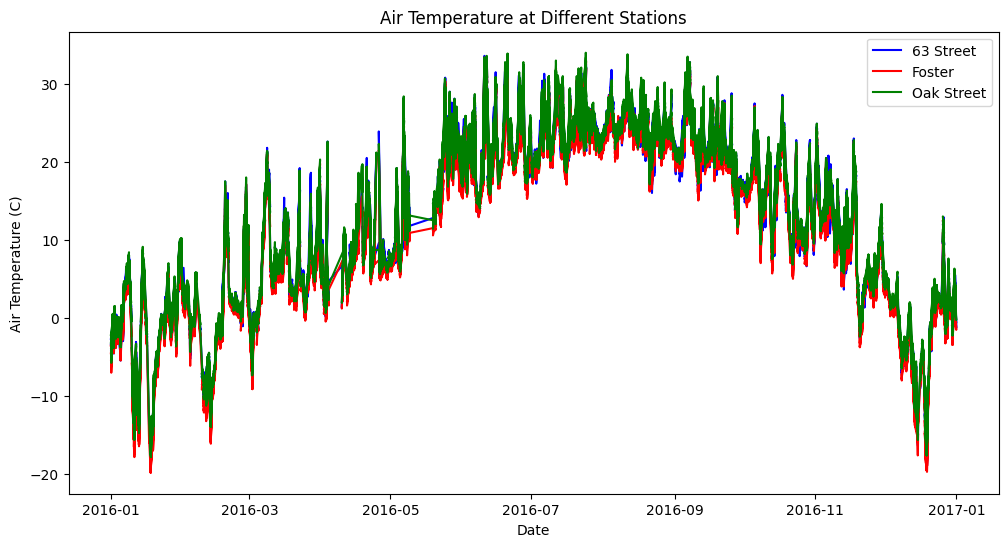

In [4]:
import matplotlib.pyplot as plt

#convert index to datetime
df_pivoted.index = pd.to_datetime(df_pivoted.index)

plt.figure(figsize=(12,6))
plt.plot(df_pivoted.index, df_pivoted['63rd Street Weather Station'], label='63 Street', color='blue')
plt.plot(df_pivoted.index, df_pivoted['Foster Weather Station'], label='Foster', color='red')
plt.plot(df_pivoted.index, df_pivoted['Oak Street Weather Station'], label='Oak Street', color='green')

plt.xlabel('Date')
plt.ylabel('Air Temperature (C)')
plt.title('Air Temperature at Different Stations')
plt.legend()
plt.show()

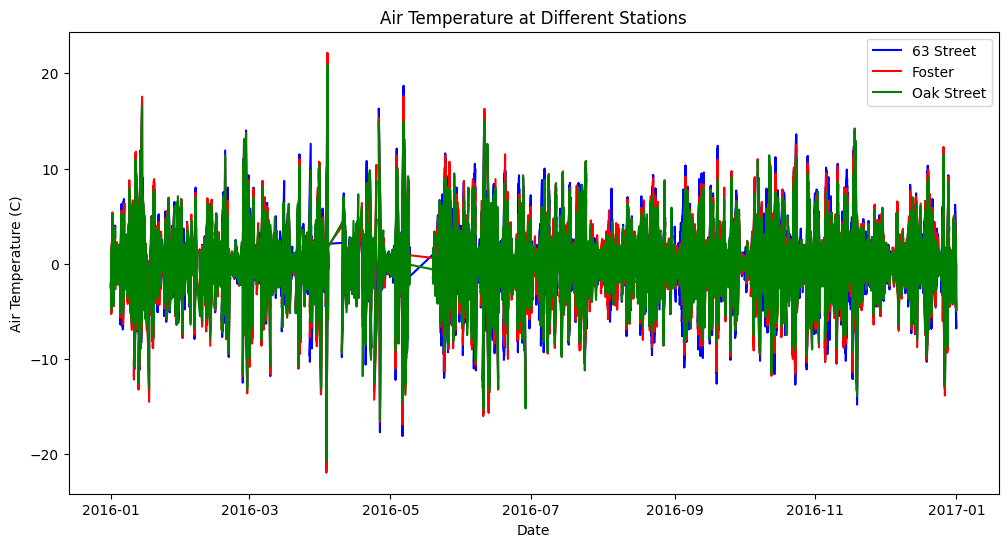

In [5]:
#data is not stationary, so we need to difference the data
df_pivoted_diff = df_pivoted.diff()
df_pivoted_diff = df_pivoted_diff.iloc[1:]

plt.figure(figsize=(12,6))
plt.plot(df_pivoted_diff.index, df_pivoted_diff['63rd Street Weather Station'], label='63 Street', color='blue')
plt.plot(df_pivoted_diff.index, df_pivoted_diff['Foster Weather Station'], label='Foster', color='red')
plt.plot(df_pivoted_diff.index, df_pivoted_diff['Oak Street Weather Station'], label='Oak Street', color='green')

plt.xlabel('Date')
plt.ylabel('Air Temperature (C)')
plt.title('Air Temperature at Different Stations')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

#let's check for stationarity using adafuller - low p value indicates stationarity
def check_stationarity(df_pivoted_diff):
    for station in df_pivoted_diff.columns:
        adf_result = adfuller(df_pivoted_diff[station])
        print(f"p-value for {station}: {adf_result[1]}")

print("Stationarity of original data")
check_stationarity(df_pivoted)

print("\nStationarity of differenced data")
check_stationarity(df_pivoted_diff)

Stationarity of original data
p-value for 63rd Street Weather Station: 0.0063832254302234855
p-value for Foster Weather Station: 0.006243883226673966
p-value for Oak Street Weather Station: 0.007041819499242206

Stationarity of differenced data
p-value for 63rd Street Weather Station: 0.0
p-value for Foster Weather Station: 0.0
p-value for Oak Street Weather Station: 0.0


The differenced data looks much better visually and the adafuller test gives much better p-value.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
#First, let's build a naive baseline, this just predicts uses the current value as the pred
for station in df_pivoted_diff.columns:
    actual = df_pivoted_diff[station].iloc[1:]
    naive_pred = df_pivoted_diff[station].iloc[:-1]
    
    mse = mean_squared_error(actual, naive_pred)
    r2 = r2_score(actual, naive_pred)

    print(f"Station: {station}, MSE: {mse}, R2: {r2}")


Station: 63rd Street Weather Station, MSE: 64.6654593639576, R2: -2.6977750786454893
Station: Foster Weather Station, MSE: 59.75514985050286, R2: -2.681848025273813
Station: Oak Street Weather Station, MSE: 52.827643381353624, R2: -2.6648505974262453


as expected, the mse/r2 metrics are pretty terrible for our naive baseline; let's try something more sophisticated like a GBR model next

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

#create features to train on - lags and sin/cos

feature_df = df_pivoted_diff.copy()
feature_df['Hour'] = feature_df.index.hour
feature_df['daily_sin'] = np.sin(2 * np.pi * feature_df['Hour'] / 24)
feature_df['daily_cos'] = np.cos(2 * np.pi * feature_df['Hour'] / 24)

for station in df_pivoted_diff.columns:
    feature_df[f'{station}_lag1'] = df_pivoted_diff[station].shift(1)
    feature_df[f'{station}_lag2'] = df_pivoted_diff[station].shift(2)
    feature_df[f'{station}_lag24'] = df_pivoted_diff[station].shift(24)
    feature_df[f'{station}_lag48'] = df_pivoted_diff[station].shift(48)
    

#add targets to feature_df
feature_df['target'] = df_pivoted_diff[station]

feature_df = feature_df.dropna()

In [35]:
from sklearn.model_selection import train_test_split

gbr_models = {}

for station in df_pivoted_diff.columns:
    print(f"Training GBR model for {station}")
    
    X = feature_df[[f'{station}_lag1', f'{station}_lag2', f'{station}_lag24', f'{station}_lag48', 'daily_sin', 'daily_cos']]
    y = feature_df[station]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    gbr_model.fit(X_train, y_train)
    gbr_models[station] = gbr_model
    
    y_pred = gbr_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
        
    print(f"Station: {station}, MSE: {mse}, R2: {r2}\n")

Training GBR model for 63rd Street Weather Station
Station: 63rd Street Weather Station, MSE: 3.6823174225716953, R2: 0.7958666540938437

Training GBR model for Foster Weather Station
Station: Foster Weather Station, MSE: 3.9514507935939793, R2: 0.772057351400578

Training GBR model for Oak Street Weather Station
Station: Oak Street Weather Station, MSE: 3.783132877591918, R2: 0.7559631659347972



Ok, now that we have trained our GBR model let's try making a prediction.

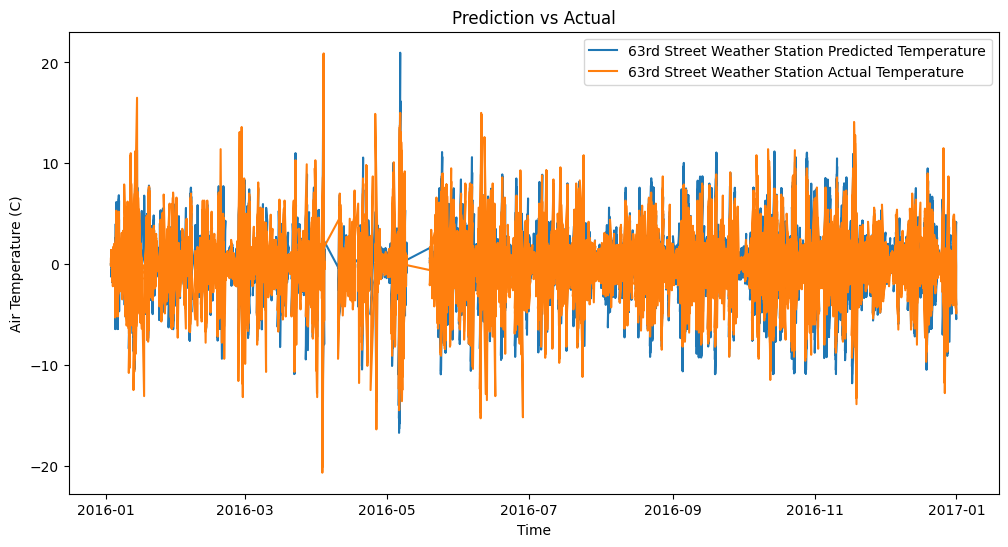

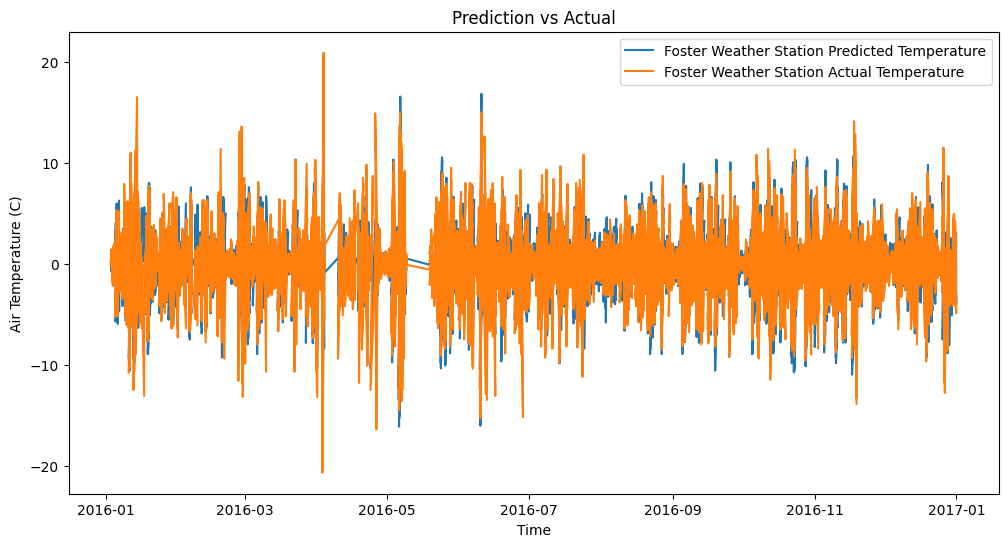

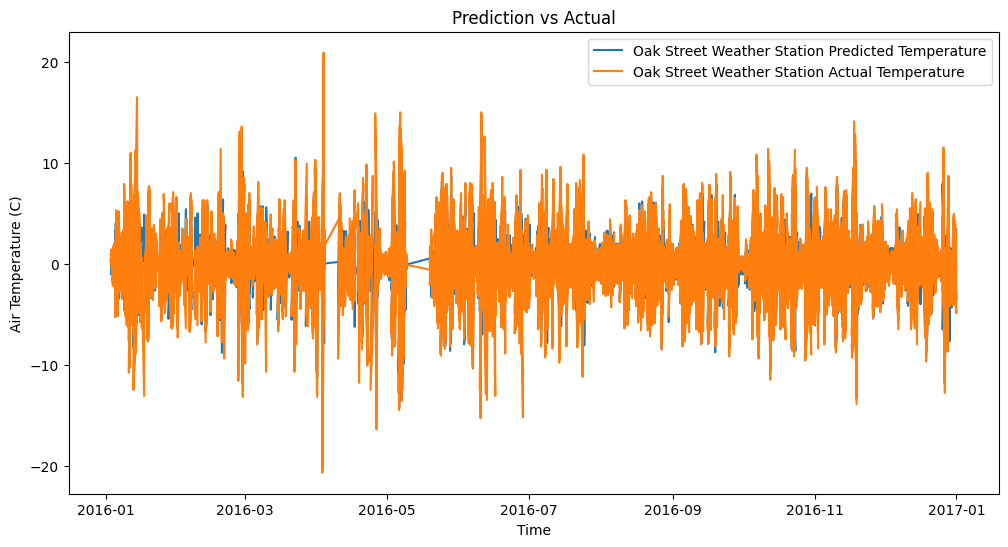

In [40]:
#Let's take a look and compare predictions to actual values

for station in df_pivoted_diff.columns:
    X = feature_df[[f'{station}_lag1', f'{station}_lag2', f'{station}_lag24', f'{station}_lag48', 'daily_sin', 'daily_cos']]
    Y = feature_df['target']
    temp_pred = gbr_models[station].predict(X)    
    
    #add timestamps to preds and plot
    preds = pd.DataFrame(temp_pred, index=X.index)
    preds.index = pd.to_datetime(preds.index)
    actuals = pd.DataFrame(Y, index=X.index)
    actuals.index = pd.to_datetime(actuals.index)
    
    plt.figure(figsize=(12,6))
    plt.plot(preds, label=f'{station} Predicted Temperature')
    plt.plot(actuals, label=f'{station} Actual Temperature')

    plt.xlabel('Time')
    plt.ylabel('Air Temperature (C)')
    plt.title('Prediction vs Actual')
    plt.legend()
    plt.show()
